## Visualize Explanations

This notebook showcases the following expainer methods on pretrained models (DecoyMNIST MLP/CNN. The XIL losses utilize them to generate the models explanation. These model explanations are compared against the user feedback masks. Keep in mind that we currently do not use theses explanatio methods to generate the user feedback masks, as we are using predefined ground-truth masks in evaluation.  

### Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.nn import functional as F

from learner.models import dnns
from learner.learner import Learner
from data_store.datasets import decoy_mnist, decoy_mnist_CE_augmented, isic_2019
from xil_methods.xil_loss import RRRGradCamLoss, RRRLoss, CDEPLoss, HINTLoss, RBRLoss
import util
import explainer

LR = 0.001
SEED = [1, 10, 100, 1000, 10000]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[Using {DEVICE} device]")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[Using cuda device]


## Load CNN model 
Define which methods with which regularization rate to visualize

In [8]:
model = dnns.SimpleConvNet().to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
n = 0  # defines which XIL method to use/ visualize
util.seed_all(SEED[n])
reg = [None, 10, 10, 1000000, 2000000, 10000 , None]
methods = ['Vanilla', 'RRR', 'RRRGradCAM', 'RBR', 'CDEP', 'HINT', 'CE']
IMAGE_INDICES = [34] # [i for i in range(20,28)]

[Using Seed= 1]


### MNIST

Loading dataset from existing file!


/tmp/ipykernel_5270/389611865.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(cur_save_name ,cmap='gray', bbox_inches='tight')


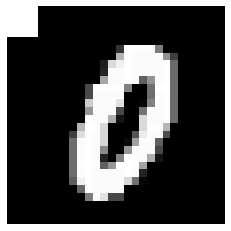

Model DecoyMnist-CNN-RRR--reg=10--seed=1--run=0 loaded! Was trained on RRRLoss() for 0 epochs!
explanation image with name IG_MNIST_RRR-34 saved!
explanation image with name GRADCAM_MNIST_RRR-34 saved!


  0%|          | 0/1000 [00:00<?, ?it/s]

explanation image with name LIME_MNIST_RRR-34 saved!


In [9]:
train_loader, test_loader = decoy_mnist(device=DEVICE, batch_size=256)
for j,data in enumerate(train_loader):
    cur_save_name = 'output_images/noXIL_MNIST.png'
    import matplotlib.pyplot as plt
    import numpy as np
    plt.imshow(np.transpose((data[0][IMAGE_INDICES][0].cpu().detach().numpy()), (1,2,0)),cmap='gray')
    plt.axis('off')
    plt.savefig(cur_save_name ,cmap='gray', bbox_inches='tight')
    plt.show()
    plt.close()
    if j == 0:
        break
               
i = 0
pretrained_modelname = f'DecoyMnist-CNN-{methods[i]}--reg={reg[i]}--seed={SEED[n]}--run={n}'
learner = Learner(model, loss, optimizer, DEVICE, pretrained_modelname, load=True)
explainer.explain_with_ig_one_by_one(learner.model, train_loader, specified_img_indices=IMAGE_INDICES, save_name=f'IG_MNIST_{methods[i]}', next_to_each_other=True)
explainer.explain_with_captum_one_by_one('grad_cam', learner.model, train_loader, specified_img_indices=IMAGE_INDICES, save_name=f'GRADCAM_MNIST_{methods[i]}', flags=False, next_to_each_other=True)
explainer.explain_with_lime_one_by_one(learner.model, train_loader, specified_img_indices=IMAGE_INDICES, save_name=f'LIME_MNIST_{methods[i]}', gray_images=True, next_to_each_other=True)

### FMNIST

In [5]:
train_loader, test_loader = decoy_mnist(fmnist=True, device=DEVICE, batch_size=256)
for j,data in enumerate(train_loader):
    cur_save_name = 'output_images/noXIL_FMNIST.png'
    import matplotlib.pyplot as plt
    import numpy as np
    plt.imshow(np.transpose((data[0][IMAGE_INDICES][0].cpu().detach().numpy()), (1,2,0)),cmap='gray')
    plt.axis('off')
    plt.savefig(cur_save_name ,cmap='gray', bbox_inches='tight')
    plt.show()
    plt.close()
    if j == 0:
        break
               
i = 0
pretrained_modelname = f'DecoyFMnist-CNN-{methods[i]}--reg={reg[i]}--seed={SEED[n]}--run={n}'
learner = Learner(model, loss, optimizer, DEVICE, pretrained_modelname, load=True)
explainer.explain_with_ig_one_by_one(learner.model, train_loader, specified_img_indices=IMAGE_INDICES, save_name=f'IG_FMNIST_{methods[i]}', next_to_each_other=True)
explainer.explain_with_captum_one_by_one('grad_cam', learner.model, train_loader, specified_img_indices=IMAGE_INDICES, save_name=f'GRADCAM_FMNIST_{methods[i]}', flags=False, next_to_each_other=True)
explainer.explain_with_lime_one_by_one(learner.model, train_loader, specified_img_indices=IMAGE_INDICES, save_name=f'LIME_FMNIST_{methods[i]}', gray_images=True, next_to_each_other=True)

[Using Seed= 1]
Model DecoyFMnist-CNN-Vanilla--reg=None--seed=1--run=0 loaded! Was trained on CrossEntropyLoss() for 0 epochs!
explanation image with name IG_FMNIST_Vanilla-34 saved!


## ISIC19 Heatmaps

In [2]:
BATCH_SIZE = 16
dataloaders, loss_weights = isic_2019(batch_size=BATCH_SIZE, train_shuffle=False)
train_dataloader, test_dataloader, test_no_patches = dataloaders["train"], dataloaders["test"], dataloaders["test_no_patches"]
model = dnns.VGG16_pretrained_isic().to(DEVICE)
loss = nn.CrossEntropyLoss(weight=loss_weights.to(DEVICE))
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
n = 0
util.seed_all(SEED[n])
methods = ['Vanilla', 'RRR', 'RRR-G', 'RBR', 'CDEP', 'HINT', 'CE']
IMAGE_INDICES = [i for i in range(9,16)]

for j, data_ in enumerate(train_dataloader):
    cur_save_name = f'output_images/noXIL_ISIC19-{j}.png'
    import matplotlib.pyplot as plt
    import numpy as np
    plt.imshow(np.transpose((data_[0][IMAGE_INDICES][0].cpu().detach().numpy()), (1,2,0)))
    plt.axis('off')
    plt.savefig(cur_save_name, bbox_inches='tight')
    plt.show()
    plt.close()
    if j == IMAGE_INDICES[-1]:
        break
                
for i in range(len(methods)):
    pretrained_modelname = f'ISIC19-{methods[i]}--seed={SEED[n]}--run={n}'
    learner = Learner(model, loss, optimizer, DEVICE, pretrained_modelname, load=True)
    explainer.explain_with_ig_one_by_one(learner.model, train_dataloader, specified_img_indices=IMAGE_INDICES, save_name=f'IG_ISIC19_{methods[i]}', next_to_each_other=True)
    explainer.explain_with_captum_one_by_one('grad_cam', learner.model, train_dataloader, specified_img_indices=IMAGE_INDICES, save_name=f'GRADCAM_ISIC19_{methods[i]}', next_to_each_other=True)
    explainer.explain_with_lime_one_by_one(learner.model, train_dataloader, specified_img_indices=IMAGE_INDICES, save_name=f'LIME_ISIC19_{methods[i]}', next_to_each_other=True)


----------Dataset----------
  Read in data from .h5 files...
  --> Read in finished: Took 93 sec!
  Building datasets...
  Sizes of datasets:
  TRAIN: 17829, TEST: 2394, TEST_NO_PATCHES: 2556
  TRAIN class dist: Counter({0: 15768, 1: 2061})
  TRAIN patch dist: Counter({0: 10521, 1: 7308})
  TEST class dist: Counter({0: 1902, 1: 492})
  TEST_NO_PATCHES class dist: Counter({0: 2064, 1: 492})
  Loss weights: tensor([0.1146, 0.8854])
  --> Build finished: Took 3 sec!
--------Dataset Done--------

